In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchaudio
import torchaudio.transforms
from torch.utils.data import DataLoader
import pdb
import torch.optim as optim
import tqdm

In [2]:
import datasets as DS
import models
import main
from CenterLoss import CenterLoss

## Get data

In [3]:
train_dataset = DS.get_training_data()
test_dataset = DS.get_test_data()

100%|██████████| 18/18 [00:00<00:00, 2618.80it/s]

Tranform applied to data is: Spectrogram()
Tranform applied to data is: Spectrogram()


In [4]:
len(train_dataset), len(test_dataset)

(12482, 3121)

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size = 64, shuffle = True, pin_memory = True)
test_dataloader  = DataLoader(test_dataset,  batch_size = 64, shuffle = True, pin_memory = True)

5856


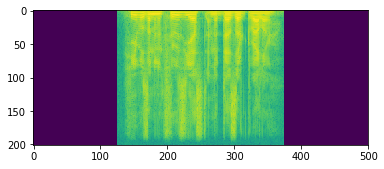

In [6]:
def display_random_specgm():
    random_index = np.random.randint(0,len(train_dataset))
    print(random_index)
    signal = train_dataset[random_index][0]
    DS.display_signal_and_spectrogram(signal[0])
display_random_specgm()

## Define Model

In [7]:
logger = main.Logger('AudioResnet34')

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = models.AudioResnet34(1, len(set(train_dataset.audio_labels)), logger = logger)
model.to(device)

AudioResnet34(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (

In [9]:
epochs = 30
criterion = nn.CrossEntropyLoss()
center_loss = CenterLoss(num_classes=len(set(train_dataset.audio_labels)), 
                         feat_dim=len(set(train_dataset.audio_labels)), use_gpu=True)

params = list(model.parameters()) + list(center_loss.parameters())
optimizer = optim.Adam(params, lr=1e-3, weight_decay=5e-3)

In [10]:
def learn(epoch, model, trainloader):
    model.train()
    
    running_loss = 0.0
    correct = 0
    total = 0
    all_predictions = []
    alpha = 0.5 # center loss weight
    
    for i, data in (enumerate(trainloader)):
        # get input and labels
        x, y = data[0].to(device), data[1].to(device)
        
        # clear out past gradients
        optimizer.zero_grad()
        
        # forward pass
        yhat = model(x)
        ce_loss = criterion(yhat, y)
        
        # combine using centre loss and CE loss
        loss = alpha * center_loss(yhat, y) + ce_loss
        
        # backward step
        loss.backward()
        for param in center_loss.parameters():
            param.grad.data *= (1. / alpha)
        
        # update parameters
        optimizer.step()
        
        _, predicted = torch.max(yhat.data, 1)
        total   += y.size(0)
        correct += (predicted == y).sum().item()
        all_predictions.extend(list(map(lambda t: t.item(), predicted)))
        
        running_loss += loss.item()
        
        logging_interval = 20
        if ((i+1) % logging_interval == 0):
            feedback_string = 'epoch #{:2} \t batch #{:3} \t loss {:.3f} \t accuracy {:.3f}'
            print(feedback_string.format(epoch, i+1, running_loss/logging_interval, 100 * correct / total))
            model.logger.log_training(running_loss/logging_interval, 100 * correct / total)
            
#             if ((i+1) % (logging_interval*10)) == 0:
#                 counts = {}
#                 for i in all_predictions: counts[i] = 1 + counts.get(i, 0)
#                 print('counts in training are:', sorted(counts.items()))

            
            running_loss = 0.0
            correct = 0
            total = 0
            


def validate(epoch, model, dataloader):
    model.eval()
    
    correct = 0
    total = 0
    total_loss = 0.0
    all_predictions = []
    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            total_loss += criterion(outputs, labels) + 0.5 * center_loss(outputs, labels)
            
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(list(map(lambda x: x.item(), predicted)))
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    num_batches = total/dataloader.batch_size
    model.logger.log_validation(total_loss.item()/num_batches, 100 * correct / total)
    print('After epoch {}, validation loss={:.3f} and accuracy={:.2f}'.format(epoch, 
                                                  total_loss.item()/num_batches, 100 * correct / total))

    
    counts = {}
    for i in all_predictions: counts[i] = 1 + counts.get(i, 0)
#     print('counts in validation are:', sorted(counts.items()))



In [11]:
def train():
    for epoch in tqdm.tqdm(range(1,epochs+1)):
        # train for an epoch
        learn(epoch, model, train_dataloader)
        # validate 
        validate(epoch, model, test_dataloader)
        # save the model
        if epoch%3 == 0: model.save_model(optimizer)
        # display graphs
        if epoch%3 == 0: model.display_training_graphs()

In [12]:
train()

  0%|          | 0/30 [00:00<?, ?it/s]

epoch # 1 	 batch # 20 	 loss 12.853 	 accuracy 6.172
epoch # 1 	 batch # 40 	 loss 11.432 	 accuracy 7.969
epoch # 1 	 batch # 60 	 loss 10.600 	 accuracy 9.766
epoch # 1 	 batch # 80 	 loss 10.327 	 accuracy 10.469
epoch # 1 	 batch #100 	 loss 9.697 	 accuracy 11.250
epoch # 1 	 batch #120 	 loss 9.392 	 accuracy 10.781
epoch # 1 	 batch #140 	 loss 8.913 	 accuracy 12.188
epoch # 1 	 batch #160 	 loss 8.741 	 accuracy 11.641
epoch # 1 	 batch #180 	 loss 8.337 	 accuracy 12.969


  3%|▎         | 1/30 [04:37<2:14:04, 277.41s/it]

After epoch 1, validation loss=10.611 and accuracy=5.16
epoch # 2 	 batch # 20 	 loss 8.524 	 accuracy 12.422
epoch # 2 	 batch # 40 	 loss 7.817 	 accuracy 14.688
epoch # 2 	 batch # 60 	 loss 7.583 	 accuracy 16.094
epoch # 2 	 batch # 80 	 loss 7.205 	 accuracy 15.859
epoch # 2 	 batch #100 	 loss 6.895 	 accuracy 16.562
epoch # 2 	 batch #120 	 loss 6.399 	 accuracy 17.578
epoch # 2 	 batch #140 	 loss 6.148 	 accuracy 16.797
epoch # 2 	 batch #160 	 loss 6.062 	 accuracy 20.156
epoch # 2 	 batch #180 	 loss 5.700 	 accuracy 19.219


  7%|▋         | 2/30 [09:25<2:10:59, 280.69s/it]

After epoch 2, validation loss=9.397 and accuracy=1.35
epoch # 3 	 batch # 20 	 loss 5.759 	 accuracy 19.922
epoch # 3 	 batch # 40 	 loss 5.213 	 accuracy 19.844
epoch # 3 	 batch # 60 	 loss 4.924 	 accuracy 23.672
epoch # 3 	 batch # 80 	 loss 4.808 	 accuracy 24.141
epoch # 3 	 batch #100 	 loss 4.656 	 accuracy 23.203
epoch # 3 	 batch #120 	 loss 4.574 	 accuracy 27.422
epoch # 3 	 batch #140 	 loss 4.417 	 accuracy 26.250
epoch # 3 	 batch #160 	 loss 4.315 	 accuracy 27.969
epoch # 3 	 batch #180 	 loss 4.326 	 accuracy 28.750
After epoch 3, validation loss=6.560 and accuracy=12.08


 10%|█         | 3/30 [14:15<2:07:33, 283.45s/it]

epoch # 4 	 batch # 20 	 loss 4.423 	 accuracy 29.922
epoch # 4 	 batch # 40 	 loss 4.078 	 accuracy 33.125
epoch # 4 	 batch # 60 	 loss 4.004 	 accuracy 35.000
epoch # 4 	 batch # 80 	 loss 3.937 	 accuracy 34.453
epoch # 4 	 batch #100 	 loss 3.960 	 accuracy 33.672
epoch # 4 	 batch #120 	 loss 3.859 	 accuracy 36.016
epoch # 4 	 batch #140 	 loss 3.742 	 accuracy 36.016
epoch # 4 	 batch #160 	 loss 3.777 	 accuracy 37.422
epoch # 4 	 batch #180 	 loss 3.775 	 accuracy 35.469


 13%|█▎        | 4/30 [19:05<2:03:38, 285.33s/it]

After epoch 4, validation loss=7.845 and accuracy=13.71
epoch # 5 	 batch # 20 	 loss 4.374 	 accuracy 33.516
epoch # 5 	 batch # 40 	 loss 3.783 	 accuracy 39.375
epoch # 5 	 batch # 60 	 loss 3.617 	 accuracy 42.188
epoch # 5 	 batch # 80 	 loss 3.587 	 accuracy 40.781
epoch # 5 	 batch #100 	 loss 3.551 	 accuracy 43.438
epoch # 5 	 batch #120 	 loss 3.516 	 accuracy 43.438
epoch # 5 	 batch #140 	 loss 3.434 	 accuracy 45.938
epoch # 5 	 batch #160 	 loss 3.421 	 accuracy 42.734
epoch # 5 	 batch #180 	 loss 3.436 	 accuracy 43.359


 17%|█▋        | 5/30 [23:55<1:59:26, 286.65s/it]

After epoch 5, validation loss=6.385 and accuracy=12.24
epoch # 6 	 batch # 20 	 loss 3.625 	 accuracy 39.922
epoch # 6 	 batch # 40 	 loss 3.379 	 accuracy 46.172
epoch # 6 	 batch # 60 	 loss 3.288 	 accuracy 48.906
epoch # 6 	 batch # 80 	 loss 3.239 	 accuracy 49.766
epoch # 6 	 batch #100 	 loss 3.246 	 accuracy 49.531
epoch # 6 	 batch #120 	 loss 3.153 	 accuracy 53.594
epoch # 6 	 batch #140 	 loss 3.134 	 accuracy 52.188
epoch # 6 	 batch #160 	 loss 3.210 	 accuracy 51.562
epoch # 6 	 batch #180 	 loss 3.189 	 accuracy 52.891
After epoch 6, validation loss=4.151 and accuracy=42.52


 20%|██        | 6/30 [28:45<1:55:03, 287.64s/it]

epoch # 7 	 batch # 20 	 loss 3.404 	 accuracy 48.672
epoch # 7 	 batch # 40 	 loss 3.220 	 accuracy 52.266
epoch # 7 	 batch # 60 	 loss 3.053 	 accuracy 58.672
epoch # 7 	 batch # 80 	 loss 3.035 	 accuracy 57.812
epoch # 7 	 batch #100 	 loss 2.993 	 accuracy 57.031
epoch # 7 	 batch #120 	 loss 2.941 	 accuracy 57.891
epoch # 7 	 batch #140 	 loss 2.931 	 accuracy 58.594
epoch # 7 	 batch #160 	 loss 2.920 	 accuracy 61.094
epoch # 7 	 batch #180 	 loss 2.905 	 accuracy 60.234


 23%|██▎       | 7/30 [33:34<1:50:29, 288.24s/it]

After epoch 7, validation loss=4.095 and accuracy=40.56
epoch # 8 	 batch # 20 	 loss 3.075 	 accuracy 59.141
epoch # 8 	 batch # 40 	 loss 2.989 	 accuracy 58.281
epoch # 8 	 batch # 60 	 loss 2.863 	 accuracy 63.672
epoch # 8 	 batch # 80 	 loss 2.792 	 accuracy 65.312
epoch # 8 	 batch #100 	 loss 2.778 	 accuracy 64.688
epoch # 8 	 batch #120 	 loss 2.779 	 accuracy 63.828
epoch # 8 	 batch #140 	 loss 2.703 	 accuracy 67.344
epoch # 8 	 batch #160 	 loss 2.730 	 accuracy 66.484
epoch # 8 	 batch #180 	 loss 2.739 	 accuracy 66.641


 27%|██▋       | 8/30 [38:24<1:45:49, 288.59s/it]

After epoch 8, validation loss=4.350 and accuracy=33.29
epoch # 9 	 batch # 20 	 loss 2.775 	 accuracy 66.719
epoch # 9 	 batch # 40 	 loss 2.694 	 accuracy 66.484
epoch # 9 	 batch # 60 	 loss 2.670 	 accuracy 70.859
epoch # 9 	 batch # 80 	 loss 2.636 	 accuracy 71.484
epoch # 9 	 batch #100 	 loss 2.681 	 accuracy 70.078
epoch # 9 	 batch #120 	 loss 2.654 	 accuracy 70.469
epoch # 9 	 batch #140 	 loss 2.612 	 accuracy 70.469
epoch # 9 	 batch #160 	 loss 2.644 	 accuracy 71.641
epoch # 9 	 batch #180 	 loss 2.545 	 accuracy 74.219
After epoch 9, validation loss=7.252 and accuracy=7.66


 30%|███       | 9/30 [43:13<1:41:06, 288.87s/it]

epoch #10 	 batch # 20 	 loss 2.731 	 accuracy 68.359
epoch #10 	 batch # 40 	 loss 2.604 	 accuracy 72.266
epoch #10 	 batch # 60 	 loss 2.556 	 accuracy 74.688
epoch #10 	 batch # 80 	 loss 2.546 	 accuracy 75.078
epoch #10 	 batch #100 	 loss 2.532 	 accuracy 73.516
epoch #10 	 batch #120 	 loss 2.460 	 accuracy 74.922
epoch #10 	 batch #140 	 loss 2.471 	 accuracy 75.859
epoch #10 	 batch #160 	 loss 2.514 	 accuracy 74.688
epoch #10 	 batch #180 	 loss 2.464 	 accuracy 75.703


 33%|███▎      | 10/30 [48:02<1:36:15, 288.76s/it]

After epoch 10, validation loss=4.454 and accuracy=33.71
epoch #11 	 batch # 20 	 loss 2.457 	 accuracy 78.828
epoch #11 	 batch # 40 	 loss 2.490 	 accuracy 77.266
epoch #11 	 batch # 60 	 loss 2.438 	 accuracy 76.172
epoch #11 	 batch # 80 	 loss 2.423 	 accuracy 76.797
epoch #11 	 batch #100 	 loss 2.434 	 accuracy 77.891
epoch #11 	 batch #120 	 loss 2.406 	 accuracy 77.344
epoch #11 	 batch #140 	 loss 2.378 	 accuracy 77.734
epoch #11 	 batch #160 	 loss 2.402 	 accuracy 78.438
epoch #11 	 batch #180 	 loss 2.380 	 accuracy 79.766


 37%|███▋      | 11/30 [52:49<1:31:15, 288.21s/it]

After epoch 11, validation loss=4.154 and accuracy=32.97
epoch #12 	 batch # 20 	 loss 2.433 	 accuracy 76.406
epoch #12 	 batch # 40 	 loss 2.387 	 accuracy 78.594
epoch #12 	 batch # 60 	 loss 2.371 	 accuracy 77.656
epoch #12 	 batch # 80 	 loss 2.320 	 accuracy 79.922
epoch #12 	 batch #100 	 loss 2.320 	 accuracy 80.625
epoch #12 	 batch #120 	 loss 2.314 	 accuracy 81.953
epoch #12 	 batch #140 	 loss 2.315 	 accuracy 78.203
epoch #12 	 batch #160 	 loss 2.319 	 accuracy 80.625
epoch #12 	 batch #180 	 loss 2.321 	 accuracy 78.203
After epoch 12, validation loss=3.822 and accuracy=37.04


 40%|████      | 12/30 [57:33<1:26:06, 287.02s/it]

epoch #13 	 batch # 20 	 loss 2.412 	 accuracy 78.047
epoch #13 	 batch # 40 	 loss 2.341 	 accuracy 80.312
epoch #13 	 batch # 60 	 loss 2.297 	 accuracy 80.469
epoch #13 	 batch # 80 	 loss 2.274 	 accuracy 80.391
epoch #13 	 batch #100 	 loss 2.280 	 accuracy 79.062
epoch #13 	 batch #120 	 loss 2.238 	 accuracy 81.719
epoch #13 	 batch #140 	 loss 2.268 	 accuracy 79.531
epoch #13 	 batch #160 	 loss 2.234 	 accuracy 82.031
epoch #13 	 batch #180 	 loss 2.228 	 accuracy 80.625


 43%|████▎     | 13/30 [1:02:14<1:20:50, 285.31s/it]

After epoch 13, validation loss=2.376 and accuracy=78.15
epoch #14 	 batch # 20 	 loss 2.251 	 accuracy 80.938
epoch #14 	 batch # 40 	 loss 2.247 	 accuracy 79.922
epoch #14 	 batch # 60 	 loss 2.245 	 accuracy 81.719
epoch #14 	 batch # 80 	 loss 2.266 	 accuracy 80.781
epoch #14 	 batch #100 	 loss 2.232 	 accuracy 80.625
epoch #14 	 batch #120 	 loss 2.185 	 accuracy 81.094
epoch #14 	 batch #140 	 loss 2.182 	 accuracy 83.281
epoch #14 	 batch #160 	 loss 2.198 	 accuracy 81.641
epoch #14 	 batch #180 	 loss 2.194 	 accuracy 81.641


 47%|████▋     | 14/30 [1:06:54<1:15:41, 283.83s/it]

After epoch 14, validation loss=5.212 and accuracy=16.18
epoch #15 	 batch # 20 	 loss 2.265 	 accuracy 79.609
epoch #15 	 batch # 40 	 loss 2.200 	 accuracy 81.172
epoch #15 	 batch # 60 	 loss 2.181 	 accuracy 81.250
epoch #15 	 batch # 80 	 loss 2.202 	 accuracy 81.328
epoch #15 	 batch #100 	 loss 2.158 	 accuracy 83.438
epoch #15 	 batch #120 	 loss 2.129 	 accuracy 83.203
epoch #15 	 batch #140 	 loss 2.137 	 accuracy 84.531
epoch #15 	 batch #160 	 loss 2.139 	 accuracy 83.828
epoch #15 	 batch #180 	 loss 2.164 	 accuracy 83.750
After epoch 15, validation loss=2.909 and accuracy=70.33


 50%|█████     | 15/30 [1:11:34<1:10:38, 282.60s/it]

epoch #16 	 batch # 20 	 loss 2.152 	 accuracy 83.984
epoch #16 	 batch # 40 	 loss 2.143 	 accuracy 83.516
epoch #16 	 batch # 60 	 loss 2.094 	 accuracy 83.516
epoch #16 	 batch # 80 	 loss 2.130 	 accuracy 86.250
epoch #16 	 batch #100 	 loss 2.114 	 accuracy 82.969
epoch #16 	 batch #120 	 loss 2.107 	 accuracy 84.375
epoch #16 	 batch #140 	 loss 2.106 	 accuracy 84.844
epoch #16 	 batch #160 	 loss 2.082 	 accuracy 86.719
epoch #16 	 batch #180 	 loss 2.119 	 accuracy 84.219


 53%|█████▎    | 16/30 [1:16:13<1:05:39, 281.40s/it]

After epoch 16, validation loss=6.135 and accuracy=15.99
epoch #17 	 batch # 20 	 loss 2.203 	 accuracy 81.406
epoch #17 	 batch # 40 	 loss 2.148 	 accuracy 84.609
epoch #17 	 batch # 60 	 loss 2.144 	 accuracy 85.859
epoch #17 	 batch # 80 	 loss 2.122 	 accuracy 86.016
epoch #17 	 batch #100 	 loss 2.093 	 accuracy 83.672
epoch #17 	 batch #120 	 loss 2.090 	 accuracy 86.406
epoch #17 	 batch #140 	 loss 2.107 	 accuracy 84.609
epoch #17 	 batch #160 	 loss 2.086 	 accuracy 86.406
epoch #17 	 batch #180 	 loss 2.067 	 accuracy 87.188


 57%|█████▋    | 17/30 [1:20:46<1:00:25, 278.90s/it]

After epoch 17, validation loss=5.403 and accuracy=18.78
epoch #18 	 batch # 20 	 loss 2.153 	 accuracy 84.219
epoch #18 	 batch # 40 	 loss 2.098 	 accuracy 86.875
epoch #18 	 batch # 60 	 loss 2.078 	 accuracy 86.875
epoch #18 	 batch # 80 	 loss 2.038 	 accuracy 89.141
epoch #18 	 batch #100 	 loss 2.041 	 accuracy 88.828
epoch #18 	 batch #120 	 loss 2.050 	 accuracy 88.281
epoch #18 	 batch #140 	 loss 2.082 	 accuracy 86.797
epoch #18 	 batch #160 	 loss 2.035 	 accuracy 87.734
epoch #18 	 batch #180 	 loss 2.029 	 accuracy 87.734
After epoch 18, validation loss=1.964 and accuracy=89.81


 60%|██████    | 18/30 [1:25:17<55:19, 276.65s/it]  

epoch #19 	 batch # 20 	 loss 2.069 	 accuracy 87.188
epoch #19 	 batch # 40 	 loss 2.052 	 accuracy 87.500
epoch #19 	 batch # 60 	 loss 2.054 	 accuracy 89.297
epoch #19 	 batch # 80 	 loss 2.051 	 accuracy 87.109
epoch #19 	 batch #100 	 loss 2.049 	 accuracy 87.969
epoch #19 	 batch #120 	 loss 2.036 	 accuracy 89.609
epoch #19 	 batch #140 	 loss 2.015 	 accuracy 89.297
epoch #19 	 batch #160 	 loss 2.004 	 accuracy 90.938
epoch #19 	 batch #180 	 loss 2.003 	 accuracy 88.906


 63%|██████▎   | 19/30 [1:29:47<50:21, 274.66s/it]

After epoch 19, validation loss=7.455 and accuracy=7.63
epoch #20 	 batch # 20 	 loss 2.035 	 accuracy 88.750
epoch #20 	 batch # 40 	 loss 2.027 	 accuracy 90.078
epoch #20 	 batch # 60 	 loss 2.061 	 accuracy 90.859
epoch #20 	 batch # 80 	 loss 2.034 	 accuracy 90.312
epoch #20 	 batch #100 	 loss 2.034 	 accuracy 91.172
epoch #20 	 batch #120 	 loss 2.036 	 accuracy 89.922
epoch #20 	 batch #140 	 loss 2.033 	 accuracy 89.922
epoch #20 	 batch #160 	 loss 2.014 	 accuracy 91.641
epoch #20 	 batch #180 	 loss 2.014 	 accuracy 91.094


 67%|██████▋   | 20/30 [1:34:16<45:29, 272.93s/it]

After epoch 20, validation loss=5.023 and accuracy=18.17
epoch #21 	 batch # 20 	 loss 2.000 	 accuracy 91.875
epoch #21 	 batch # 40 	 loss 2.008 	 accuracy 92.344
epoch #21 	 batch # 60 	 loss 2.029 	 accuracy 90.938
epoch #21 	 batch # 80 	 loss 2.002 	 accuracy 93.203
epoch #21 	 batch #100 	 loss 1.976 	 accuracy 92.266
epoch #21 	 batch #120 	 loss 1.974 	 accuracy 91.953
epoch #21 	 batch #140 	 loss 1.988 	 accuracy 93.281
epoch #21 	 batch #160 	 loss 1.988 	 accuracy 92.812
epoch #21 	 batch #180 	 loss 1.965 	 accuracy 93.828
After epoch 21, validation loss=2.219 and accuracy=85.52


 70%|███████   | 21/30 [1:38:44<40:43, 271.51s/it]

epoch #22 	 batch # 20 	 loss 2.038 	 accuracy 91.328
epoch #22 	 batch # 40 	 loss 2.034 	 accuracy 91.406
epoch #22 	 batch # 60 	 loss 2.008 	 accuracy 91.797
epoch #22 	 batch # 80 	 loss 2.009 	 accuracy 92.031
epoch #22 	 batch #100 	 loss 1.980 	 accuracy 93.594
epoch #22 	 batch #120 	 loss 1.992 	 accuracy 92.812
epoch #22 	 batch #140 	 loss 1.977 	 accuracy 93.438
epoch #22 	 batch #160 	 loss 2.002 	 accuracy 92.891
epoch #22 	 batch #180 	 loss 1.996 	 accuracy 92.734


 73%|███████▎  | 22/30 [1:43:11<35:59, 269.94s/it]

After epoch 22, validation loss=2.550 and accuracy=64.53
epoch #23 	 batch # 20 	 loss 2.047 	 accuracy 92.422
epoch #23 	 batch # 40 	 loss 1.988 	 accuracy 92.031
epoch #23 	 batch # 60 	 loss 1.987 	 accuracy 92.969
epoch #23 	 batch # 80 	 loss 1.992 	 accuracy 93.281
epoch #23 	 batch #100 	 loss 1.963 	 accuracy 93.828
epoch #23 	 batch #120 	 loss 1.951 	 accuracy 93.281
epoch #23 	 batch #140 	 loss 1.962 	 accuracy 93.672
epoch #23 	 batch #160 	 loss 1.963 	 accuracy 92.656
epoch #23 	 batch #180 	 loss 1.960 	 accuracy 93.984


 77%|███████▋  | 23/30 [1:47:36<31:20, 268.70s/it]

After epoch 23, validation loss=2.158 and accuracy=89.14
epoch #24 	 batch # 20 	 loss 1.975 	 accuracy 92.500
epoch #24 	 batch # 40 	 loss 2.000 	 accuracy 93.047
epoch #24 	 batch # 60 	 loss 1.979 	 accuracy 92.109
epoch #24 	 batch # 80 	 loss 1.978 	 accuracy 92.031
epoch #24 	 batch #100 	 loss 1.954 	 accuracy 93.281
epoch #24 	 batch #120 	 loss 1.945 	 accuracy 94.219
epoch #24 	 batch #140 	 loss 1.938 	 accuracy 94.609
epoch #24 	 batch #160 	 loss 1.934 	 accuracy 94.219
epoch #24 	 batch #180 	 loss 1.942 	 accuracy 92.578
After epoch 24, validation loss=4.574 and accuracy=19.61


 80%|████████  | 24/30 [1:52:02<26:46, 267.73s/it]

epoch #25 	 batch # 20 	 loss 1.969 	 accuracy 93.203
epoch #25 	 batch # 40 	 loss 1.932 	 accuracy 94.297
epoch #25 	 batch # 60 	 loss 1.936 	 accuracy 94.141
epoch #25 	 batch # 80 	 loss 1.952 	 accuracy 94.141
epoch #25 	 batch #100 	 loss 1.933 	 accuracy 94.375
epoch #25 	 batch #120 	 loss 1.938 	 accuracy 93.047
epoch #25 	 batch #140 	 loss 1.959 	 accuracy 93.281
epoch #25 	 batch #160 	 loss 1.939 	 accuracy 92.578
epoch #25 	 batch #180 	 loss 1.931 	 accuracy 93.125


 83%|████████▎ | 25/30 [1:56:28<22:15, 267.12s/it]

After epoch 25, validation loss=5.712 and accuracy=11.73
epoch #26 	 batch # 20 	 loss 1.979 	 accuracy 91.641
epoch #26 	 batch # 40 	 loss 1.941 	 accuracy 93.047
epoch #26 	 batch # 60 	 loss 1.947 	 accuracy 92.266
epoch #26 	 batch # 80 	 loss 1.939 	 accuracy 92.422
epoch #26 	 batch #100 	 loss 1.990 	 accuracy 93.281
epoch #26 	 batch #120 	 loss 1.937 	 accuracy 93.438
epoch #26 	 batch #140 	 loss 1.915 	 accuracy 92.969
epoch #26 	 batch #160 	 loss 1.917 	 accuracy 94.375
epoch #26 	 batch #180 	 loss 1.923 	 accuracy 92.422


 87%|████████▋ | 26/30 [2:00:53<17:46, 266.52s/it]

After epoch 26, validation loss=5.063 and accuracy=8.14
epoch #27 	 batch # 20 	 loss 1.934 	 accuracy 92.812
epoch #27 	 batch # 40 	 loss 1.920 	 accuracy 92.422
epoch #27 	 batch # 60 	 loss 1.939 	 accuracy 92.422
epoch #27 	 batch # 80 	 loss 1.956 	 accuracy 91.719
epoch #27 	 batch #100 	 loss 1.932 	 accuracy 92.266
epoch #27 	 batch #120 	 loss 1.891 	 accuracy 92.500
epoch #27 	 batch #140 	 loss 1.954 	 accuracy 93.203
epoch #27 	 batch #160 	 loss 1.929 	 accuracy 91.797
epoch #27 	 batch #180 	 loss 1.921 	 accuracy 93.906
After epoch 27, validation loss=4.726 and accuracy=23.68


 90%|█████████ | 27/30 [2:05:17<13:17, 265.71s/it]

epoch #28 	 batch # 20 	 loss 1.990 	 accuracy 90.547
epoch #28 	 batch # 40 	 loss 1.935 	 accuracy 92.422
epoch #28 	 batch # 60 	 loss 1.919 	 accuracy 93.516
epoch #28 	 batch # 80 	 loss 1.934 	 accuracy 91.562
epoch #28 	 batch #100 	 loss 1.934 	 accuracy 92.812
epoch #28 	 batch #120 	 loss 1.924 	 accuracy 91.719
epoch #28 	 batch #140 	 loss 1.889 	 accuracy 93.281
epoch #28 	 batch #160 	 loss 1.914 	 accuracy 92.266
epoch #28 	 batch #180 	 loss 1.892 	 accuracy 92.812


 93%|█████████▎| 28/30 [2:09:39<08:49, 264.70s/it]

After epoch 28, validation loss=4.278 and accuracy=33.10
epoch #29 	 batch # 20 	 loss 1.979 	 accuracy 90.156
epoch #29 	 batch # 40 	 loss 1.965 	 accuracy 90.938
epoch #29 	 batch # 60 	 loss 1.914 	 accuracy 92.500
epoch #29 	 batch # 80 	 loss 1.912 	 accuracy 92.109
epoch #29 	 batch #100 	 loss 1.895 	 accuracy 92.031
epoch #29 	 batch #120 	 loss 1.933 	 accuracy 90.156
epoch #29 	 batch #140 	 loss 1.882 	 accuracy 91.016
epoch #29 	 batch #160 	 loss 1.911 	 accuracy 91.172
epoch #29 	 batch #180 	 loss 1.892 	 accuracy 92.969


 97%|█████████▋| 29/30 [2:14:01<04:23, 263.78s/it]

After epoch 29, validation loss=3.275 and accuracy=47.97
epoch #30 	 batch # 20 	 loss 1.974 	 accuracy 90.156
epoch #30 	 batch # 40 	 loss 1.916 	 accuracy 92.109
epoch #30 	 batch # 60 	 loss 1.904 	 accuracy 92.031
epoch #30 	 batch # 80 	 loss 1.897 	 accuracy 91.562
epoch #30 	 batch #100 	 loss 1.927 	 accuracy 90.703
epoch #30 	 batch #120 	 loss 1.887 	 accuracy 91.406
epoch #30 	 batch #140 	 loss 1.886 	 accuracy 92.422
epoch #30 	 batch #160 	 loss 1.899 	 accuracy 90.156
epoch #30 	 batch #180 	 loss 1.916 	 accuracy 91.875
After epoch 30, validation loss=2.271 and accuracy=79.78


100%|██████████| 30/30 [2:18:22<00:00, 276.75s/it]


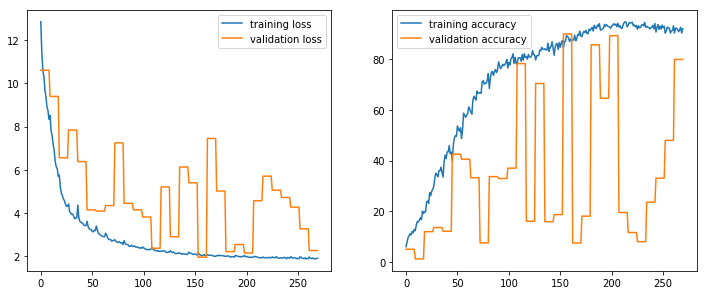

In [13]:
def plot_batch_stats():
    plt.figure("Batch loss and accuracy", figsize=(4.8*2.5, 4.8))
    
    def plot_losses():
        ratio = int(len(model.logger.training_loss)/len(model.logger.validation_loss))
        l = [ [i]*ratio for i in model.logger.validation_loss ]
        adjusted_validation_loss = []
        for e in l: adjusted_validation_loss.extend(e)
            
        plt.figure("Batch loss and accuracy")
        plt.subplot(121)
        plt.plot(model.logger.training_loss, label = 'training loss')
        plt.plot(adjusted_validation_loss, label = 'validation loss')
        plt.legend()
        
    def plot_accuracies():
        ratio = int(len(model.logger.training_accuracy)/len(model.logger.validation_accuracy))        
        l = [ [i]*ratio for i in model.logger.validation_accuracy ]
        adjusted_validation_acc = []
        for e in l: adjusted_validation_acc.extend(e)
            
        plt.figure("Batch loss and accuracy")
        plt.subplot(122)
        plt.plot(model.logger.training_accuracy, label = 'training accuracy')
        plt.plot(adjusted_validation_acc, label = 'validation accuracy')
        plt.legend()

    plot_losses()
    plot_accuracies()
#     plt.show("Batch loss and accuracy")
plot_batch_stats()

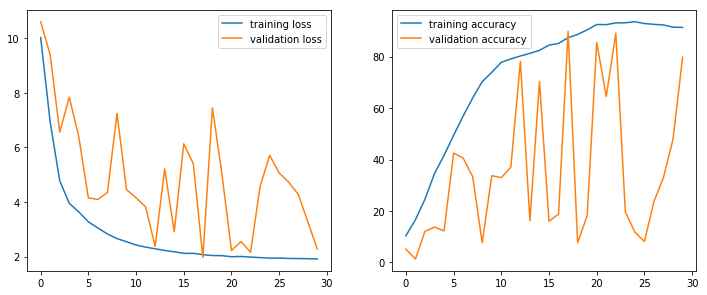

In [14]:
def plot_epoch_stats():

    plt.figure("Epoch loss and accuracies", figsize=(4.8*2.5, 4.8))

    def plot_losses_epoch():
        ratio = int(len(model.logger.training_loss)/len(model.logger.validation_loss))
        l = [ model.logger.training_loss[i:i+ratio] for i in range(0,len(model.logger.training_loss),ratio) ]
        adjusted_training_loss = []
        for e in l: adjusted_training_loss.append(sum(e)/len(e))

        plt.figure("Epoch loss and accuracies")
        plt.subplot(121)
        plt.plot(adjusted_training_loss, label = 'training loss')
        plt.plot(model.logger.validation_loss, label = 'validation loss')
        plt.legend()


    def plot_acc_epoch():
        ratio = int(len(model.logger.training_accuracy)/len(model.logger.validation_accuracy))
        l = [ model.logger.training_accuracy[i:i+ratio] for i in range(0,len(model.logger.training_accuracy),ratio) ]
        adjusted_training_acc = []
        for e in l: adjusted_training_acc.append(sum(e)/len(e))
            
        plt.figure("Epoch loss and accuracies")
        plt.subplot(122)
        plt.plot(adjusted_training_acc, label = 'training accuracy')
        plt.plot(model.logger.validation_accuracy, label = 'validation accuracy')
        plt.legend()
    
    plot_acc_epoch()
    plot_losses_epoch()

plot_epoch_stats()

In [66]:
from sklearn.manifold import TSNE

In [59]:
def get_test_data():
    model.eval()
    X = torch.Tensor().to(device)
    Y = torch.zeros(()).new_empty(0, dtype=torch.int, device = device)
    
    with torch.no_grad():
        for data in test_dataloader:
            x, y = data
            x, y = x.to(device), y.to(device).int()
            outputs = model(x)
            X = torch.cat((X, outputs), dim=0)
            Y = torch.cat((Y, y), dim=0)
    return X, Y

# X, Y = get_test_data()

In [70]:
def get_embeddings():
    '''
    iterate over test dataloader
    get forward embeddings
    stack embeddings
    use t-sne
    '''
    print("getting embeddings...")
    X, Y = get_test_data()
    X, Y = X.cpu().numpy(), Y.cpu().numpy()
    print("getting projections...")
    projector = TSNE(n_components=2, perplexity=15, learning_rate=10)
    projections = projector.fit_transform(X)
    print("done.")
    return projections, Y

projections, Y = get_embeddings()

getting embeddings...
getting projections...
done.


In [76]:
Y

array([ 1, 15, 10, ..., 14, 10, 11], dtype=int32)

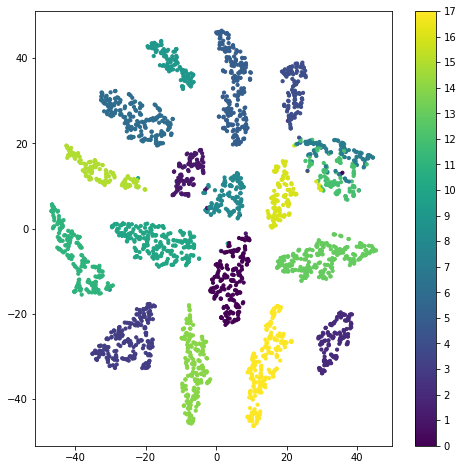

In [92]:
def show_projections(projections, y):
    
    # plot the result
    vis_x = projections[:, 0]
    vis_y = projections[:, 1]

    plt.figure('TSNE Projections', figsize=(8,8))
    plt.scatter(vis_x, vis_y, c=y, s=10)
    plt.colorbar(ticks=range(len(set(y))))
#     plt.clim(-0.5, 9.5)
    plt.show()
#     plt.legend(set(y))
show_projections(projections, Y)


In [97]:
def check_loading_works():
    '''
    check if loading old saved models works
    '''
    newLogger_test = main.Logger("AudioResNet")
    newModel_test = models.AudioResnet34(1, len(train_dataset.idx_to_labels),logger=newLogger_test)
    newOptimizer_test = optim.Adam(list(newModel_test.parameters()) + list(CenterLoss(18, 18).parameters()))
    
    newModel_test.load_saved_model('./SavedModels/AudioResnet34_epoch21_accuracy85.pt', newOptimizer_test)
    print('done.')
    pdb.set_trace()
    newModel_test.parameters()
check_loading_works()   

done.
> <ipython-input-97-c1b03ebfc7b8>(12)check_loading_works()
-> newModel_test.parameters()
(Pdb) newModel_test
AudioResnet34(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): Batch

(Pdb) newModel_test.fc
Linear(in_features=512, out_features=50, bias=True)
(Pdb) newModel_test.fc.__get_attr__(
*** SyntaxError: unexpected EOF while parsing
(Pdb) newModel_test.fc.__get_attr__()
*** AttributeError: 'Linear' object has no attribute '__get_attr__'
(Pdb) newModel_test.fc.__getattr__()
*** TypeError: __getattr__() missing 1 required positional argument: 'name'
(Pdb) q


BdbQuit: 

In [106]:
list(model.parameters())[].shape

torch.Size([64, 64, 3, 3])

In [107]:
summary(model)

NameError: name 'summary' is not defined

In [108]:
sum([param.nelement() for param in model.parameters()])

21305032